<a href="https://colab.research.google.com/github/furewing/dataAnalysis/blob/main/2_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_05_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%88%98%EC%A7%91_OpenAPI_%EC%99%84%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 분석

## 5. OpenAPI를 이용한 데이터 수집

- <a href="#1)OpenAPI통한데이터수집">1) OpenAPI 통한 데이터 수집</a>
- <a href="#2)한글텍스트Cleansing">2) 한글 텍스트 Cleansing</a>
- <a href="#3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

### #그래프에서 한글사용하는 방법
- **(코랩에서)한글폰트 설치하기**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>런타임 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,998 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and dire

- **한글 폰트 지정하기**

In [1]:
# 코랩에서 한글 폰트 종류와 이름이 win과 다를 수 있다!!!
# 코랩: NanumGothic, 윈도우: Malgun Gothic
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'NanumGothic',
                     'font.size': 12,
                     'figure.figsize': (6, 4),
                     'axes.unicode_minus':  False }) # 폰트 설정

---

### <a name="1)OpenAPI통한데이터수집">1) OpenAPI 통한 데이터 수집</a>

#### 1.네이버 OpenAPI 신청하기
* 네이버 검색(책, 뉴스, 쇼핑)
    - 네이버 OpenAPI 소개: https://developers.naver.com/products/intro/plan/
    - 개발 가이드 보기: https://developers.naver.com/docs/serviceapi/search/news
    - OpenAPI 신청하기: https://developers.naver.com/apps/#/register

#### 2.네이버 OpenAPI 사용하기
* 검색
    - 1.책 검색
    - 2.뉴스 검색
    - 3.쇼핑 검색

#### [실습] : 네이버 검색 API 사용하여 데이터 수집하기

In [ ]:
# 정적 크롤링을 위한 requests 설치
!pip install requests

In [19]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

now = datetime.datetime.now()
datas = []   #csv파일을 위한 변수

client_id = '2ncSRLqCo7sueptuV2td'          # 자신의 client_id
client_pw = 'DAscf_KRc8'          # 자신의 client_secret
PATH = './'         # 수집 데이터 저장 폴더


#[CODE 1]
def get_RequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_pw)

    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
            return response.read().decode('utf-8')

    except Exception as e:
#         if response.getcode() == 400 and datas:
#             return None
        print(e)
        print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Error for URL : {url}" )
        return None


#[CODE 2]  네이버 검색 API
def get_NaverSearch(node, keyword, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(keyword), start, display)

    url = base + node + parameters
    responseDecode = get_RequestUrl(url)   #[CODE 1]

    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

#[CODE 3]
def get_PostData(node, post, jsonResult, cnt):
    if node == 'book':
        data = {'제목':post['title'],
                '저자':post['author'],
                '출판사':post['publisher'],
                '출간일':post['pubdate'],
                '링크':post['link'],
                '이미지':post['image']}
    elif node == 'news':
        data = {'제목':post['title'],
                '링크':post['originallink'],
                '내용':post['description']}
    elif node == 'shop':
        data = {'제목':post['title'],
                '브랜드':post['brand'],
                '제조사':post['maker'],
                '가격':post['lprice'],
                '이미지':post['image']}

    jsonResult.append(data)
    datas.append(data)

    return

#[CODE 0]
def main():
    global node, keyword

    nodeType = '''-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------'''
    print(nodeType)
    node = input('번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]')
    if node == '1': node = 'book'
    elif node == '2': node = 'news'
    elif node == '3': node = 'shop'
    else:
        node == '1'
        node = 'book'

    keyword = input(f'{node} 검색할 검색어를 입력하세요: ')

    display, cnt = 100, 0
    jsonResult = []
    jsonResponse = get_NaverSearch(node, keyword, 1, display)  #[CODE 2]
    total = jsonResponse['total']

    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
        for post in jsonResponse['items']:
            cnt += 1
            get_PostData(node, post, jsonResult, cnt)  #[CODE 3]

        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = get_NaverSearch(node, keyword, start, total)
#     print(f'가져올 데이터 : {total} 건')

    # with open(f'{PATH}/naver_{node}_{keyword}', 'w', encoding='utf8') as outfile:
    #     jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)

    #     outfile.write(jsonFile)

    print("가져온 데이터 : %d 건" %(cnt))



    # csv 파일로 저장하기
    file = f'{PATH}/naver_{node}_{keyword}.csv'
    df = pd.DataFrame(datas)
    df.to_csv(file, index=False, encoding="utf-8-sig")
    print(f'{PATH}/naver_{node}_{keyword}.csv SAVED')
    return df

#-----------
# 시작
#-----------
df = main()
df

-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------
번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]2
news 검색할 검색어를 입력하세요: 정보
[2024년04월25일 03시39분04초] Url Request Success
HTTP Error 400: Bad Request
[2024년04월25일 03시39분04초] Error for URL : https://openapi.naver.com/v1/search/news.json?query=%EC%A0%95%EB%B3%B4&start=101&display=19373898
가져온 데이터 : 100 건
.//naver_news_정보.csv SAVED


,제목,링크,내용
0,"캡티비전, 액티비전 ·프레임워크와 손잡고 '코첼라 밸리'서 기술력 뽐내",https://www.theguru.co.kr/news/article.html?no...,G-글라스는 투명 유리의 기본 특성과 맞춤형 대규모 미디어 디스플레이 기능을 결합한...
1,"[웰스리포트] 금융자산 30억원 이상 부자, 절반은 채권 투자",https://news.einfomax.co.kr/news/articleView.h...,"외화현금의 통화 종류는 달러가 91%로 가장 많았고, 엔화 49%, 유로 15%, ..."
2,1분기 경제성장률 1.3%…수출·건설 회복에 2년여 만 최고,https://www.busan.com/view/busan/view.php?code...,"수출도 휴대전화 등 <b>정보</b>기술(IT) 품목을 중심으로 0.9% 성장했고,..."
3,제주대 '2024 제주 향토 문화 활용 상표/디자인 &amp; IP <b>정보</b...,http://www.veritas-a.com/news/articleView.html...,IP <b>정보</b> 활용 발명아이디어 경진대회'를 개최한다고 25일 밝혔다. 작...
4,"27개 지역을 건 전투, 레드랩 '롬' 영지전 공개",https://www.gamemeca.com/mv.php?inflow=naver&g...,▲ 롬 영지전 공개 이미지 (사진제공: 레드랩게임즈) 레드랩게임즈는 25일 MMOR...
...,...,...,...
95,"`1분기 GDP 1.3%` 최상목 &quot;우리 경제, 교과서적 성장경로로 복귀&...",https://www.dt.co.kr/contents.html?article_no=...,"이 자리에는 과학기술<b>정보</b>통신부와 외교부, 농림축산식품부, 산업통상자원부..."
96,박서련 “다른 세상은 항상 가능하다”,http://ch.yes24.com/Article/View/55481,"카카듀에 대한 글을 읽었는데, 인터넷 곳곳에 산발적으로 카카듀에 대한 <b>정보</..."
97,"현대엔지니어링, 유튜브에 배우 김석훈과 함께한 사회공헌활동 콘텐츠 공개",https://www.onews.tv/news/articleView.html?idx...,현대엔지니어링 공식 유튜브 채널의 '현엔클라쓰' 코너는 현대엔지니어링이 전개하고 있...
98,"컴투스 신작 ‘스타시드: 아스니아 트리거’, 최강의 검사 '시아' 등장",https://www.thisisgame.com/webzine/game/nboard...,"픽업 모집은 스티비트 또는 픽업 프록시안 모집권으로 참여할 수 있으며, 시아를 승급..."




---



#### (24.2.29 서비스 종료됨)[실습] :  네이버 Papago API 사용하여 번역하기

In [ ]:
# import os
# import sys
# import urllib.request
# import datetime
# import json


# client_id = ''  # 자신의 파파고 NMT API ID
# client_pw = ''            # 자신의 파파고 NMT API PASSWORD

# news = []   #csv파일을 위한 변수

# #[CODE 1]
# def papago(prompt, lang=1):

#     encText = urllib.parse.quote(prompt)
#     if lang == 1 :
#         data = "source=ko&target=en&text=" + encText
#     else:
#         data = "source=en&target=ko&text=" + encText
#     url = "https://openapi.naver.com/v1/papago/n2mt"

#     req = urllib.request.Request(url)
#     req.add_header("X-Naver-Client-Id", client_id)
#     req.add_header("X-Naver-Client-Secret", client_pw)

#     try:
#         response = urllib.request.urlopen(req, data=data.encode("utf-8") )
#         if response.getcode() == 200:
#             print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
#             responseDecode = response.read().decode('utf-8')

#             if responseDecode == None:
#                 return None
#             else:
#                 return json.loads(responseDecode)

#     except Exception as e:
#         print(e)
#         print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
#         return None

# # 메인
# lang= int(input('[선택] 1:한글->영어, 2:영어->한글: '))
# txt =  '한글' if lang==1 else '영어'
# prompt= input(f'[번역] 변환할 문장을 입력하세요.[{txt}로 입력]: ')

# jsonResponse = papago(prompt, lang)  # 파파고 번역
# jsonResponse
# print('-'*50)
# print(f"[번역 결과] => {jsonResponse['message']['result']['translatedText']}")


-------------------------

### <a name="2)한글텍스트Cleansing">2) 한글 텍스트 Cleansing</a>

#### 1.라이브러리 설치

In [4]:
# 자연어처리 형태소 분석 및 토큰화
!pip install nltk

In [3]:
# (한글)자연어처리 형태소 분석 및 토큰화
# (WinOS에서는 konlpy를 사용하기 위해 JDK를 설치해야 오류가 없어 코랩에서 실행함)
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 40.4 MB/s eta 0:00:00


In [5]:
# html tag parsing을 위한 라이브러리
!pip install beautifulsoup4

In [6]:
# 사이킷런 CountVectorizer클래스 사용 : 단어 빈도수 추출
!pip install scikit-learn

#### 2.한글 테스트 자연어 처리(Text Cleansing)
- 앞에서 OpenAPI를 사용하여 뉴스 데이터를 가져온 뒤에 아래 코트를 실행시키도록 한다.


In [20]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import konlpy
import nltk

def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    for i, document in enumerate(documents):
        document = BeautifulSoup(document, 'html.parser').text
        documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = []
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)

    return documents


def clean_target_feature(data):
    x_data = data.to_list()
    return clean_korean_documents(x_data)



# ---------------------
# 1.클린징할 파일 가져오기
file = f'{PATH}/naver_{node}_{keyword}.csv'  # 앞에서 만들어진 파일 사용하기
#file = 'naver_news_세븐틴.csv'
df = pd.read_csv(file)

# 2.클린징할 컬럼 선택해서 클린징하기
# (앞 OpenAPI검색에서 2.news 검색을 한 후 실행하기)
df['제목'] = clean_target_feature(df['제목'])  # 기사 제목
df['내용'] = clean_target_feature(df['내용'])  # 기사 내용

# 3.클린징 결과 csv 파일로 저장하기
file = f'{PATH}/naver_{node}_{keyword}_clean.csv'
df.to_csv(file, index=False, encoding="utf-8-sig")
print(f'{file} SAVED')

df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


.//naver_news_정보_clean.csv SAVED


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,제목,링크,내용
0,캡 티비 전 액티비전 프레임워크 손잡다 코첼라 밸리 기술 뽐내다,https://www.theguru.co.kr/news/article.html?no...,글라스 투명 유리 기본 특성 맞춤 대규모 미디어 디스플레이 기능 결합 융 복합 정보...
1,웰스 리포트 금융 자산 억원 이상 부자 절반 채권 투자,https://news.einfomax.co.kr/news/articleView.h...,외화 현금 통화 종류 달러 로 가장 많다 엔화 유로 위안화 순 이다 보다 기사 인포...
2,분기 경제성장률 수출 건설 회복 만 최고,https://www.busan.com/view/busan/view.php?code...,수출 휴대전화 정보기술 품목 중심 성장하다 민간 소비 의류 재화 음식 숙박 서비스 ...
3,제주 제주 향토 문화 활용 상표 디자인 정보 활용 발명 아이디어,http://www.veritas-a.com/news/articleView.html...,정보 활용 발명 아이디어 경진 대회 개최 하다 밝히다 작품 접수 월일 코드 통한 관...
4,지역 건 전투 레드 랩 롬 전 공개,https://www.gamemeca.com/mv.php?inflow=naver&g...,롬 전 공개 이미지 사진 제공 레드 랩 게임 레드 랩 게임 는 롬 이하 롬 전투 컨...


#### 3.워드 클라우드 만들기

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 말뭉치를 토큰화하여 빈도수 가져오기
def get_wordTokenCount(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # 말뭉치를 토큰화하기
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수로 정렬하고 토큰명 추출
    idx = np.argsort(-count)  # 내림 정렬하여 인덱스 반환: 토큰의 인덱스
    count = count[idx]        # 토큰의 빈도수
    feature_name = np.array(vect.get_feature_names_out())[idx]  # 토큰값

    # 빈도수 많은 순서대로 토큰명 10개만 출력
    print(list(zip(feature_name, count))[:10])

    return feature_name, count


# 단어(토큰) 빈도수 막대 그래프 그리기
def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'./token_bar_graph.png')

# 워드클라우드 만들기
def make_wordcloud(feature_name, count):
    # 한글 폰트 경로를 설정
    font_path = 'NanumGothic'  #/usr/share/fonts/truetype/nanum/NanumGothic.ttf  #코랩
    #font_path = 'malgun'  # C:/Windows/Fonts/                                  #window

    # (토큰명, 빈도수) 딕셔너리 타입으로 변환
    data = dict(zip(feature_name, count))

    # 워드클라우드로 그래프로 시각화
    wc = WordCloud(width = 1000, height = 600, background_color="black", font_path=font_path)
    plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
    plt.axis("off")
    plt.show()

    # 이미지 파일로 저장하기
    wc.to_file(f'./워드클라우드.png')


[('협약', 7), ('오늘', 7), ('긴급', 6), ('민희진', 6), ('분기', 6), ('성장', 6), ('기자회견', 6), ('삼성', 5), ('체결', 5), ('업무', 5)]


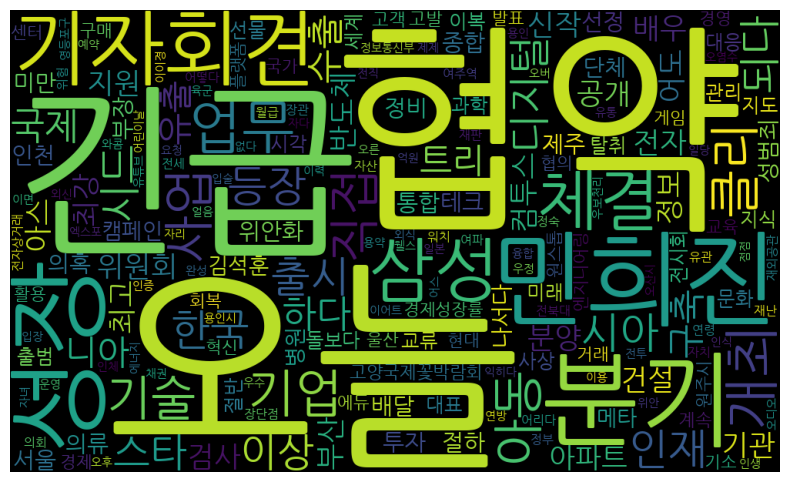

In [27]:
import pandas as pd

# 1.텍스트 말뭉치(corpus) 데이터 지정하기
corpus = df['제목'].to_list()
# print(corpus)

# 2.말뭉치를 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(corpus)

# 3.단어(토큰) 빈도수 막대 그래프 그리기(상위 10개)
# draw_wordTokenCountGraph(feature_name[:10], count[:10])

# 3.워드 클라우드 만들기
make_wordcloud(feature_name, count)

In [23]:
!pip install wordcloud

In [24]:
!pip install matplotlib



---



### <a name="3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

#### 1.웹 이미지 화면에 출력하기

In [30]:
from IPython.display import Image
#Image(url='https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg')
Image(url='https://shopping-phinf.pstatic.net/main_4680640/46806403618.20240402132129.jpg')

#### 2.웹 이미지 파일로 저장하기

In [29]:
import requests
from io import BytesIO
from PIL import Image

# 다운받을 이미지 url
urls = [
    "https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg",
    "https://shopping-phinf.pstatic.net/main_3726611/37266116619.20230119071117.jpg"
]
# 파일로 저장하기
for idx, url in enumerate(urls):
    res = requests.get(url)                   # url 요청
    img = Image.open(BytesIO(res.content))    # 응답결과(res.content)바이트파일 이미지 파일로 오픈
    img.save(f'./testimg_{idx}.png', 'png')   # 'png'이미지로(만) 저장

#### [실습] : 웹 이미지 수집하기
- 앞에서 저장한 쇼핑 목록에 있는 URL을 이용하여 이미지 저장하기

In [33]:
# 이미지 다운로드 하기
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import time
import os

# 자신에게 맞게 폴더/파일 위치 정보를 수정한다.
FILE = f'./naver_shop_루이비통.csv'  # 앞에서 자신이 검색한 쇼핑 파일
ImgFolder = f'./download/'      # 다운받을 이미지 폴더
MAX = 20                              # 이미지 파일 다운로드 건수

def getImageUrl(file):
    print(f'읽은 파일명: {file}')
    df = pd.read_csv(file, encoding='utf-8') # 이미지가 있는 쇼핑 파일 불러오기
    return df['이미지'].to_list()

def createDirectory(directory): # 다운받을 이미지 폴더 만들기
    try:
        if not os.path.exists(directory):
            print(f'{directory} 폴더가 생성되었습니다.')
            os.makedirs(directory)
        print(f'이미지 폴더 위치 : {directory}')
    except OSError:
        print("Error: Failed to create the directory.")

def downloadImageFile(urls, imgfolder):
    start = time.time()             # 이미지 다운로드 속도 time check
    for idx, url in enumerate(urls):
        if idx == MAX:
            break  # MAX 건수만 처리하기
        res = requests.get(url)     # request.get 요청
#         print(f'[{idx+1:2>}][{time.time() - start}] : {url}')  # 이미지 다운로드 시간 체크
        print(f'[{idx+1:0>2}] : {url}')  # 이미지 다운로드 시간 체크
        img = Image.open(BytesIO(res.content))  #Img open
        img.save(f'{imgfolder}testimage_{idx}.png', 'png')
    return idx


urls = getImageUrl(FILE)                # 이미지 URL 목록 가져오기
createDirectory(ImgFolder)              # 다운받을 이미지 폴더 만들기
totalcnt = downloadImageFile(urls, ImgFolder)      # 이미지 다운로드하기
print(f'총 다운로드 건수: {totalcnt}')


읽은 파일명: ./naver_shop_루이비통.csv
이미지 폴더 위치 : ./download/
[01] : https://shopping-phinf.pstatic.net/main_4680640/46806403618.20240402132129.jpg
[02] : https://shopping-phinf.pstatic.net/main_4648164/46481643618.20240318130833.jpg
[03] : https://shopping-phinf.pstatic.net/main_4664287/46642877618.20240326091508.jpg
[04] : https://shopping-phinf.pstatic.net/main_4567486/45674867621.20240206121135.jpg
[05] : https://shopping-phinf.pstatic.net/main_4643176/46431764618.20240315171930.jpg
[06] : https://shopping-phinf.pstatic.net/main_4568487/45684874618.20240207031226.jpg
[07] : https://shopping-phinf.pstatic.net/main_3548216/35482164618.20221027170959.jpg
[08] : https://shopping-phinf.pstatic.net/main_4187388/41873880618.20230814230439.jpg
[09] : https://shopping-phinf.pstatic.net/main_3907318/39073188618.20230331160001.jpg
[10] : https://shopping-phinf.pstatic.net/main_3556945/35569451618.20221101104851.jpg
[11] : https://shopping-phinf.pstatic.net/main_3573057/35730574618.20221109162502.jpg


---------------------------

끝!